# Phase retrieval with gradient descent
## Recovering the TinyTol pupil

In this demonstration there is a known phase solution.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

import tensorflow as tf
import pickle

from funcs import *

In [2]:
# We used TensorFlow version 2.3.0
print(tf.__version__)

2.3.0


## Define physical constants

In [3]:
apix = 128 # number of pixels in the apeture
dpix = 256 # nuber of pixels on the detector

pix_size = 1e-6 # Sampling size in the focal plane (meters)
aperture = .02  # apeture size (diameter) (meters)
flen = .15      # focal length (meters)
wlen = 600e-9   # wavelength (meters)

# Scaling factor used to pad the apperture giving the desired focal plane sampling
factor = (wlen * flen) / (aperture * pix_size)

## Load in the TinyTol pupil

In [4]:
true_pupil = np.load('./target_psfs/tinytol.npy')

pad_pupil = pad(true_pupil, factor = factor)
true_psf = tf.cast(intensity(FFT(pad_pupil)), dtype = tf.float32)

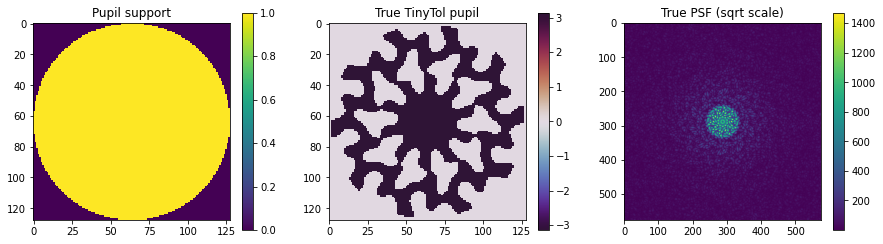

In [5]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1); plt.imshow(np.abs(true_pupil), interpolation = 'none'); plt.colorbar()
plt.title('Pupil support')

plt.subplot(1, 3, 2); plt.imshow(np.angle(true_pupil), cmap = 'twilight_shifted', vmin = -np.pi, vmax = np.pi, interpolation = 'none'); plt.colorbar()
plt.title('True TinyTol pupil')

plt.subplot(1, 3, 3); plt.imshow(true_psf**0.5); plt.colorbar()
plt.title('True PSF (sqrt scale)')

plt.show()

## Initialize gradient descent
The pupil support is known and taken from the true pupil.

In [6]:
mag = tf.abs(true_pupil)

The phases are initialized randomly between -0.5 and 0.5 radians.

In [7]:
phases = tf.random.uniform((apix, apix), minval = -0.5, maxval = 0.5, seed = 0)
pupil = build_pupil(phases, np.abs(true_pupil))
pad_pupil = pad(pupil, factor = factor)
psf = intensity(FFT(pad_pupil))

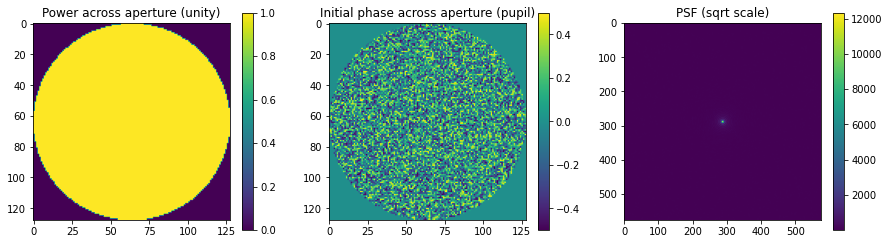

In [8]:
plt.figure(figsize = (15, 4))

plt.subplot(1, 3, 1); plt.imshow(np.abs(pupil)); plt.colorbar()
plt.title('Power across aperture (unity)')

plt.subplot(1, 3, 2); plt.imshow(np.angle(pupil)); plt.colorbar()
plt.title('Initial phase across aperture (pupil)')

plt.subplot(1, 3, 3); plt.imshow(psf**0.5); plt.colorbar()
plt.title('PSF (sqrt scale)')

plt.show()

Since we know the pupil support, we only need to recover the phase, in our gradient descent we only need to calculate gradients with respect to the phase.

In [9]:
pad_pupil = pad(pupil, factor = factor)
psf = intensity(FFT(pad_pupil))

mag = tf.abs(pad_pupil)
pha = tf.Variable(tf.math.angle(pad_pupil))

In [10]:
results = {'psfs': [], 'pupils': [], 'errors': []}

## Run gradient descent

We use the MAE as our objective function.

In [11]:
def gradient_descent(phase, magnitude, epochs, learning_rate, results, save_rate = 100):
    
    adam = tf.optimizers.Adam(learning_rate)
    
    for i in range(epochs):
        
        with tf.GradientTape() as g:
            g.watch(phase)

            pad_pupil = build_pupil(phase, magnitude) 

            fft = FFT(pad_pupil)
            psf = intensity(fft)

            error = tf.reduce_mean(tf.abs(tf.subtract(true_psf, psf)))
            results['errors'].append(error.numpy())

            if i % save_rate == 0:
                results['psfs'].append(psf)
                results['pupils'].append(pad_pupil[:apix, :apix])

            grads = g.gradient(error, phase)
        
        adam.apply_gradients(zip([grads], [phase]))
        
    results['psfs'].append(psf)
    results['pupils'].append(pad_pupil[:apix, :apix])
        
    return results

In [12]:
lr = 1

# Reduce the learning rate 5 times, running for 1000 epochs in between
for i in range(5): 
    results = gradient_descent(pha, mag, 1000, lr, results)
    lr /= 10

In [13]:
with open('./TinyTol.pkl', 'wb') as f:
    pickle.dump(results, f)

## Results

In [6]:
with open('./TinyTol.pkl', 'rb') as f:
    results = pickle.load(f)

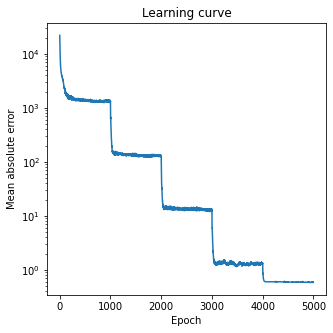

In [7]:
plt.figure(figsize = (5, 5))
plt.plot(results['errors'])
plt.yscale('log')
plt.title('Learning curve'); plt.xlabel('Epoch'); plt.ylabel('Mean absolute error')
plt.show()

## First 400 epochs of the gradient descent

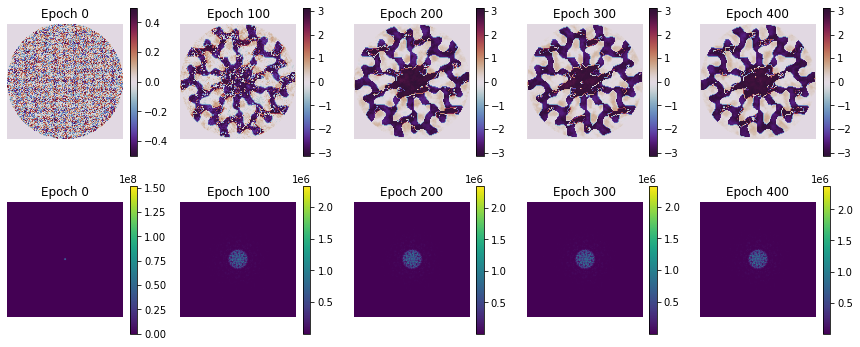

In [8]:
ncols = 5
save_rate = 100

plt.figure(figsize = (15, 6))
for i in range(ncols):
    plt.subplot(2, ncols, i + 1); plt.imshow(np.angle(results["pupils"][i]), cmap = 'twilight_shifted'); plt.colorbar(); plt.axis('off')
    plt.title("Epoch {}".format(i * save_rate))
    
    plt.subplot(2, ncols, ncols + i + 1); plt.imshow(results["psfs"][i]); plt.colorbar(); plt.axis('off')
    plt.title("Epoch {}".format(i * save_rate))
plt.show()

### Recovered pupil and PSF

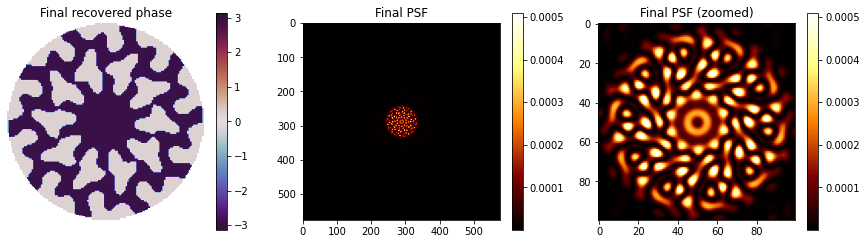

In [12]:
final_pupil = np.angle(results["pupils"][-1])
final_psf = results["psfs"][-1]

final_pupil[final_pupil == 0] = None

c = true_psf.shape[0]//2; s = 50
zoomed_psf = final_psf[c-s:c+s, c-s:c+s]

plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1); plt.imshow(final_pupil, cmap = 'twilight_shifted', vmin = -np.pi, vmax = np.pi);
plt.colorbar(); plt.title('Final recovered phase'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(normalise(final_psf), cmap = 'afmhot', vmax = 5.1e-4); plt.colorbar(); plt.title('Final PSF')
plt.subplot(1, 3, 3); plt.imshow(normalise(zoomed_psf), cmap = 'afmhot', vmax = 5.1e-4); plt.colorbar(); plt.title('Final PSF (zoomed)')
plt.show()

### True TinyTol pupil and PSF

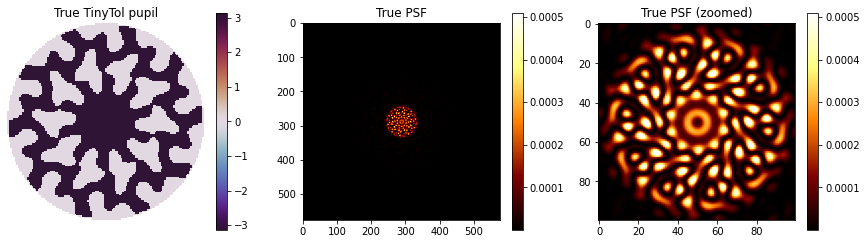

In [13]:
c = true_psf.shape[0]//2; s = 50
zoomed_psf = true_psf[c-s:c+s, c-s:c+s]

true_pupil[true_pupil == 0] = None

plt.figure(figsize = (15, 4))
plt.subplot(1, 3, 1); plt.imshow(np.angle(true_pupil), cmap = 'twilight_shifted', vmin = -np.pi, vmax = np.pi, interpolation = 'none'); 
plt.colorbar(); plt.title('True TinyTol pupil'); plt.axis('off')
plt.subplot(1, 3, 2); plt.imshow(normalise(true_psf), cmap = 'afmhot', vmax = 5.1e-4); plt.colorbar(); plt.title('True PSF')
plt.subplot(1, 3, 3); plt.imshow(normalise(zoomed_psf), cmap = 'afmhot', vmax = 5.1e-4); plt.colorbar(); plt.title('True PSF (zoomed)')
plt.show()